In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import resources
from pathlib import PurePosixPath as Path
import time

from keras.layers import Input, Dropout, BatchNormalization
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Sequential, Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load RMS signals for autoencoder

In [2]:
exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
rms = {}

VAL_EXP = 'Test 9'

for test in exps:
    rms[test] = resources.ae.RMS(test)
    rms[test].data.drop(['0', '1', '2'], axis=1, inplace=True)

try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass

for test in exps:
    rms[test]._data = rms[test].data.T.reset_index(drop=True).T

--------------------------------------------------
Loaded RMS data for "22_08_03_grit1000"
Experiemnt No: Test 5
Number of files: 213
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_07_weartest_1000"
Experiemnt No: Test 7
Number of files: 163
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_09_weartest_1000"
Experiemnt No: Test 8
Number of files: 176
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_30_weartest_1000"
Experiemnt No: Test 9
Number of files: 158
--------------------------------------------------


Remove DC component from RMS signal and section to only between trigger points

In [3]:
def remove_dc(sig):
    return sig - np.nanmean(sig)

for test in exps:
    rms[test]._data = rms[test].data.iloc[50:350, :].reset_index(drop=True)
    rms[test]._data = rms[test].data.apply(remove_dc, axis=0)

In [4]:
def combine_exps(df_list: list):
    join_df = np.concatenate(df_list, axis=1)
    join_df = pd.DataFrame(join_df)
    print(np.shape(join_df))
    return join_df

join_df = combine_exps([rms[test].data.iloc[:, :70].values for test in exps[:-1]])

(300, 210)


In [5]:
def create_join_vector(df):
    joined = []
    for i in range(np.shape(df)[1]):
        joined.extend(df.iloc[:, i].values.T)
    joined = np.array(joined).reshape(-1, 1)
    return joined

joined_rms = create_join_vector(join_df)
print(f'Number of RMS samples: {np.shape(joined_rms)}')

val_exp_rms = create_join_vector(rms[exps[-1]].data)
print(f'Number of val RMS samples: {np.shape(val_exp_rms)}')

Number of RMS samples: (63000, 1)
Number of val RMS samples: (46500, 1)


## Create sequences for autoencoder

In [6]:
SEQ_LEN = 100

def to_sequences(data, seq_len=SEQ_LEN):
    d = []
    for index in range(len(data) - seq_len + 1):
        d.append(data[index: (index + seq_len)])
    return np.stack(d)

join_rms_seq = to_sequences(joined_rms, SEQ_LEN)
print(f'Joined df input shape: {join_rms_seq.shape}')

val_exp_seq = to_sequences(val_exp_rms, SEQ_LEN)
print(f'Val input shape: {val_exp_seq.shape}')

Joined df input shape: (62901, 100, 1)
Val input shape: (46401, 100, 1)


## Split data and scale

In [7]:
NO_TRAIN_SIGS = 50
def split_data(data, n):
    test = data[(n*300):]
    train = data[:(n*300)]
    return train, test

val_exp_seq_tr, val_exp_seq_te = split_data(val_exp_seq, NO_TRAIN_SIGS)

print(f'Training input shape: {val_exp_seq_tr.shape}')
print(f'Test input shape: {val_exp_seq_te.shape}')

Training input shape: (15000, 100, 1)
Test input shape: (31401, 100, 1)


In [8]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(val_exp_seq_tr.reshape(-1, 1)).reshape(-1, SEQ_LEN, 1)
x_test = scaler.transform(val_exp_seq_te.reshape(-1, 1)).reshape(-1, SEQ_LEN, 1)

## Create Autoencoder

In [9]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = resources.config_paths()
print(TB_DIR)

/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [10]:
N_SIZE = [256, 128, 64]
N_BOTTLENECK = 32
N_FEATURES = x_train.shape[2]

def get_encoder(seq_len, n_features, n_bottleneck, n_size):
    encoder_in = Input(shape=(seq_len, n_features))
    e = encoder_in

    for dim in n_size:
        e = LSTM(dim, return_sequences=True)(e)
        e = Dropout(0.1)(e)
        e = BatchNormalization()(e)
    
    encoder_out = LSTM(n_bottleneck, return_sequences=False)(e)
    encoder = Model(encoder_in, encoder_out, name='Encoder')
    return encoder

def get_decoder(seq_len, n_features, n_bottleneck, n_size):
    decoder_in = Input(shape=(n_bottleneck,))
    d = RepeatVector(seq_len)(decoder_in)

    for dim in n_size[::-1]:
        d = LSTM(dim, return_sequences=True)(d)
        d = Dropout(0.1)(d)
        d = BatchNormalization()(d)
    
    decoder_out = TimeDistributed(Dense(n_features))(d)
    decoder = Model(decoder_in, decoder_out, name='Decoder')
    return decoder

encoder = get_encoder(SEQ_LEN, N_FEATURES, N_BOTTLENECK, N_SIZE)
decoder = get_decoder(SEQ_LEN, N_FEATURES, N_BOTTLENECK, N_SIZE)

autoencoder_in = Input(shape=(SEQ_LEN, 1), name='Input')
encoded = encoder(autoencoder_in)
decoded = decoder(encoded)
autoe = Model(autoencoder_in, decoded, name='Autoencoder')

# optimiser = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False, clipnorm=1., clipvalue=0.5)
# autoe.compile(optimizer=optimiser, loss='mean_squared_error')
# autoe.summary()

layers = N_SIZE + [N_BOTTLENECK] + N_SIZE[::-1]
T = time.strftime("%Y%m%d-%H%M%S", time.localtime())

run_name = f'LSTMAE-{VAL_EXP}-WIN-{SEQ_LEN}-L-{layers}-T-{T}'

In [11]:
autoe.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 1)]          0         
                                                                 
 Encoder (Functional)        (None, 32)                524928    
                                                                 
 Decoder (Functional)        (None, 100, 1)            519937    
                                                                 
Total params: 1,044,865
Trainable params: 1,043,073
Non-trainable params: 1,792
_________________________________________________________________


In [12]:
autoe.load_weights(
    TB_DIR.joinpath(r"AUTOE/LSTMAE_test/LSTMAE-join_df-WIN-100-E-300-L-[256, 128, 64, 32, 64, 128, 256]-20230728-110713/LSTMAE-join_df-WIN-100-E-300-L-[256, 128, 64, 32, 64, 128, 256]-20230728-110713.h5")
)

469/469 [==============================] - 112s 233ms/step


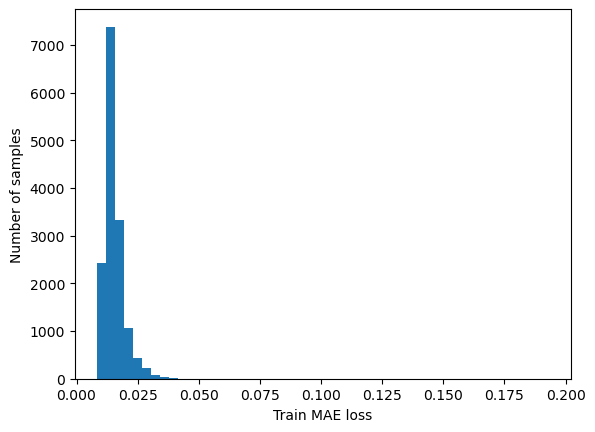

In [13]:
x_train_pred = autoe.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50);
plt.xlabel('Train MAE loss')
plt.ylabel('Number of samples');

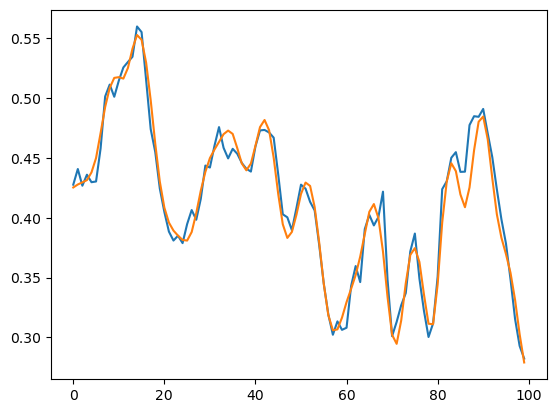

In [14]:
i = 10
plt.plot(x_train[i])
plt.plot(x_train_pred[i])

982/982 [==============================] - 227s 231ms/step


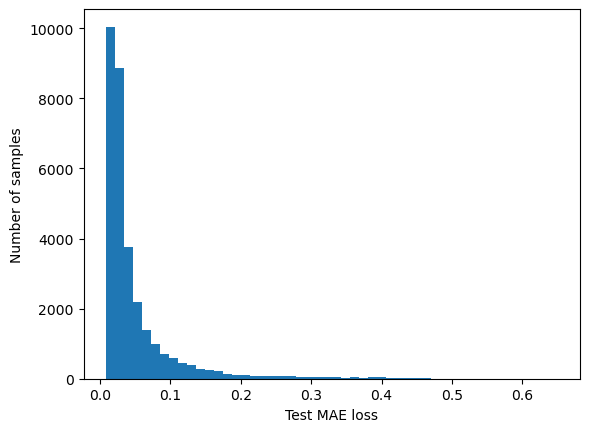

In [15]:
# Test data
x_test_pred = autoe.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(test_mae_loss, bins=50);
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

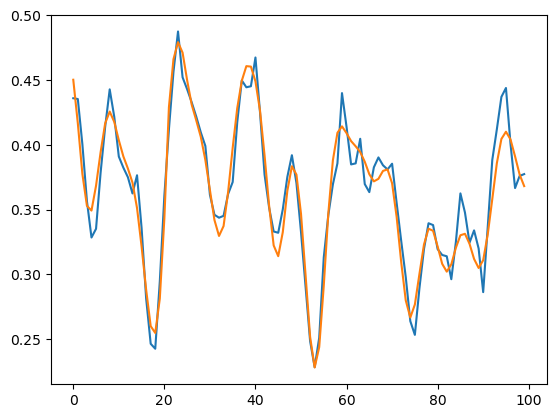

In [16]:
plt.plot(x_test[i])
plt.plot(x_test_pred[i])

In [17]:
print(f'No of train errors: {len(train_mae_loss)}')
print(f'No of test errors: {len(test_mae_loss)}\n')

# Threshold
THRESHOLD = np.percentile(train_mae_loss, 97)
print(f'Reconstruction error threshold: {THRESHOLD:3f}')


anomalies = np.concatenate([train_mae_loss, test_mae_loss], axis=0) > THRESHOLD
print(f'Number of anomaly samples: {np.sum(anomalies)}')

No of train errors: 15000
No of test errors: 31401

Reconstruction error threshold: 0.026120
Number of anomaly samples: 17650


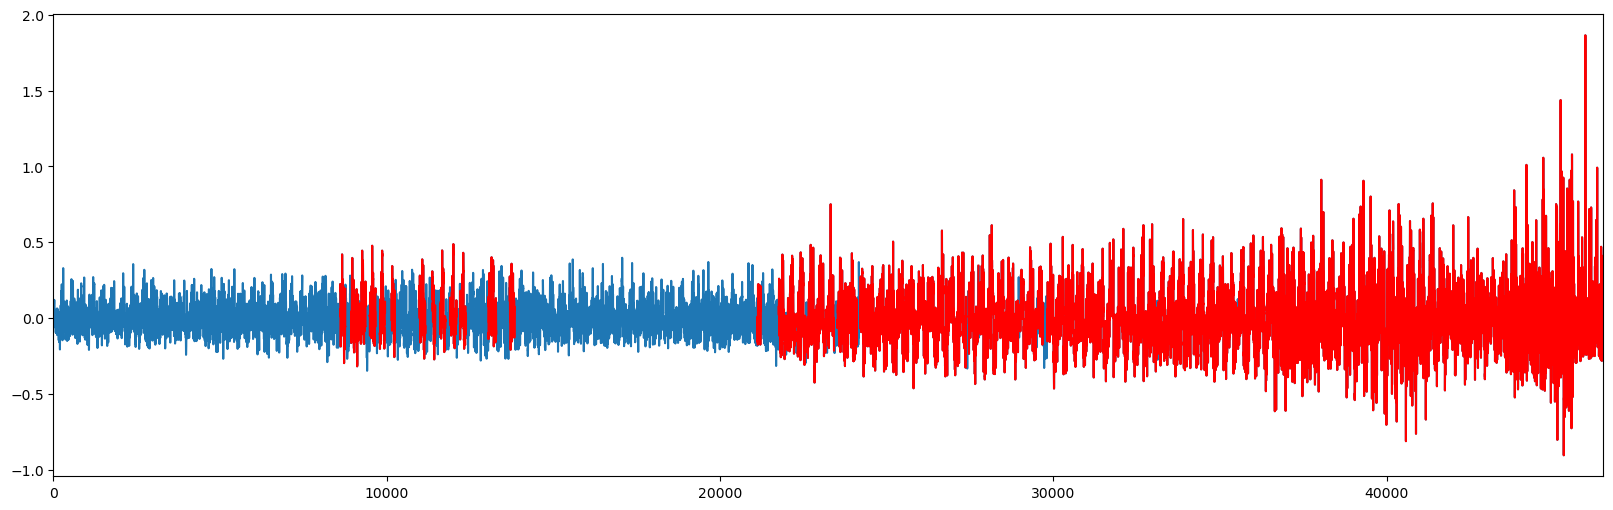

In [18]:
anomalous_data_indices = [False] * len(val_exp_rms)
np.array(anomalous_data_indices)
for i, anom in enumerate(anomalies):
    if anom:
        for j in range(i, (i + SEQ_LEN - 1)):
            anomalous_data_indices[j] = True

df_full_rms = pd.DataFrame(val_exp_rms)
df_anom = df_full_rms.copy()
df_anom.loc[np.invert(anomalous_data_indices)] = np.nan

fig, ax = plt.subplots(figsize=(20, 6))
df_full_rms.plot(legend=False, ax=ax)
df_anom.plot(legend=False, ax=ax, color="r")
plt.autoscale(enable=True, axis='x', tight=True)

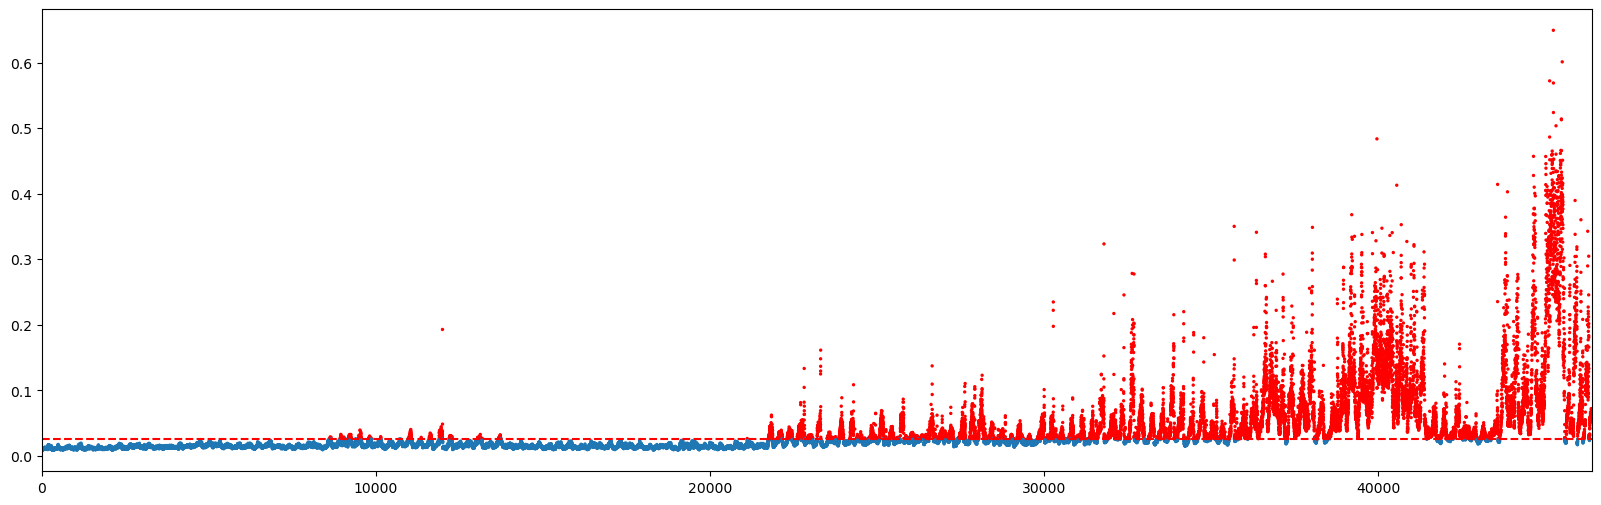

In [19]:
mae = np.concatenate([train_mae_loss, test_mae_loss], axis=0)

cmap = []
for m in mae:
    if m > THRESHOLD:
        cmap.append('r')
    else:
        cmap.append('C0')

fig, ax = plt.subplots(figsize=(20, 6))
plt.scatter(x=range(len(mae)), y=mae, c=cmap, s=2)
ax.axhline(y=THRESHOLD, color='r', linestyle='--')
plt.autoscale(enable=True, axis='x', tight=True)

In [20]:
autoe.get_layer('Encoder').trainable = False
autoe.get_layer('Encoder').trainable

False

In [21]:
# add model checkpoint callback
model_folder = TB_DIR.joinpath('AUTOE', 'TL_test')
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
assert os.path.exists(model_folder)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
        ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_folder.joinpath(run_name, f'{run_name}.h5'),
        monitor='val_loss', 
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        ),
    tf.keras.callbacks.TensorBoard(
        log_dir=model_folder.joinpath(run_name),
        )
]

In [22]:
optimiser = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False, clipnorm=1., clipvalue=0.5)
autoe.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])

In [23]:
# train model
history = autoe.fit(
    x_train, x_train,
    validation_split=0.33,
    # validation_data=(x_test, x_test),
    epochs=300,
    batch_size=64,
    use_multiprocessing=True,
    callbacks=callbacks,
)

Epoch 1/300
158/158 [==============================] - 119s 678ms/step - loss: 6.3934e-04 - mean_squared_error: 6.3934e-04 - mean_absolute_error: 0.0194 - val_loss: 7.0240e-04 - val_mean_squared_error: 7.0240e-04 - val_mean_absolute_error: 0.0195
Epoch 2/300
158/158 [==============================] - 103s 655ms/step - loss: 5.0291e-04 - mean_squared_error: 5.0291e-04 - mean_absolute_error: 0.0175 - val_loss: 6.6341e-04 - val_mean_squared_error: 6.6341e-04 - val_mean_absolute_error: 0.0193
Epoch 3/300
158/158 [==============================] - 103s 655ms/step - loss: 5.3606e-04 - mean_squared_error: 5.3606e-04 - mean_absolute_error: 0.0180 - val_loss: 6.5805e-04 - val_mean_squared_error: 6.5805e-04 - val_mean_absolute_error: 0.0190
Epoch 4/300
158/158 [==============================] - 105s 663ms/step - loss: 5.1947e-04 - mean_squared_error: 5.1947e-04 - mean_absolute_error: 0.0178 - val_loss: 6.2646e-04 - val_mean_squared_error: 6.2646e-04 - val_mean_absolute_error: 0.0187
Epoch 5/300


In [24]:
# reload best model
autoe = tf.keras.saving.load_model(model_folder.joinpath(run_name, f'{run_name}.h5'))

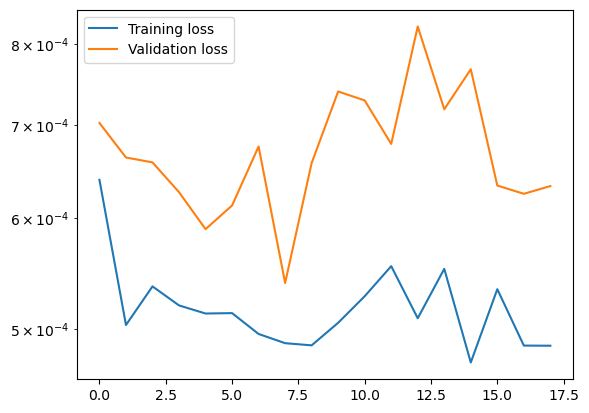

In [25]:
# plot training loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.legend();

In [26]:
# rn = TB_DIR.joinpath('AUTOE', 'LSTMAE-Test 8-WIN-100-L-[256, 128, 64, 32, 16, 32, 64, 128, 256]-T-20230719-104249', 'LSTMAE-Test 8-WIN-100-L-[256, 128, 64, 32, 16, 32, 64, 128, 256]-T-20230719-104249.h5')
# print(os.path.exists(rn))
# autoe = tf.keras.saving.load_model(rn)

469/469 [==============================] - 112s 235ms/step


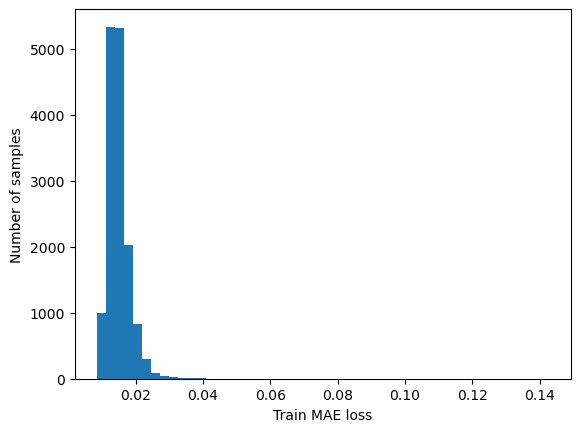

In [27]:
x_train_pred = autoe.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50);
plt.xlabel('Train MAE loss')
plt.ylabel('Number of samples');

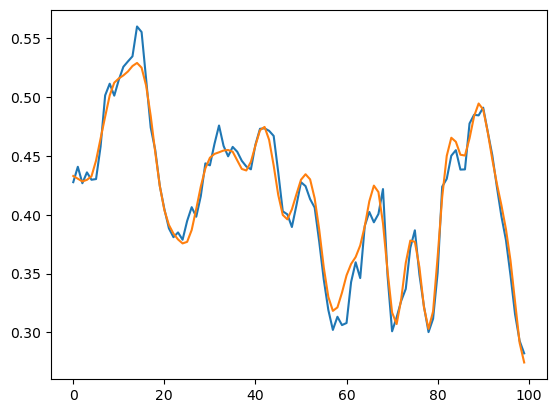

In [28]:
i = 10
plt.plot(x_train[i])
plt.plot(x_train_pred[i])

982/982 [==============================] - 231s 235ms/step


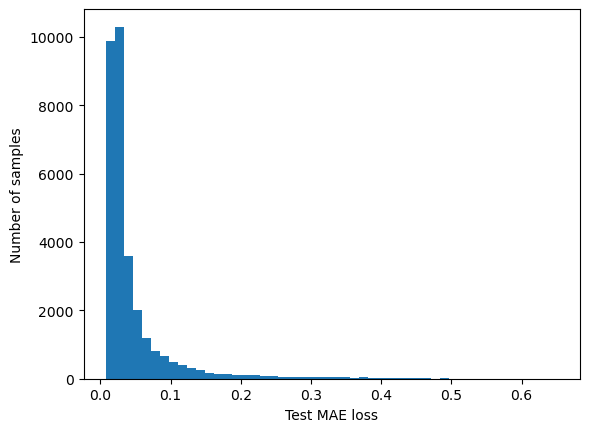

In [29]:
# Test data
x_test_pred = autoe.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(test_mae_loss, bins=50);
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

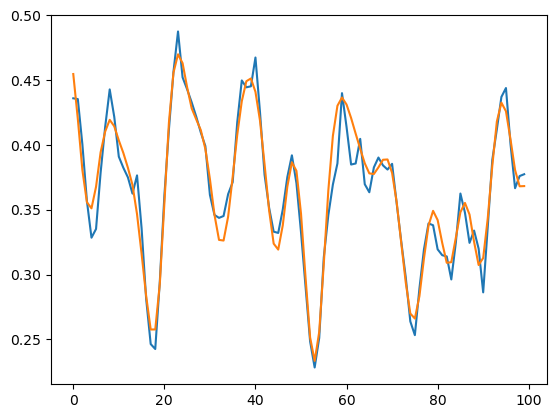

In [30]:
plt.plot(x_test[i])
plt.plot(x_test_pred[i])

In [31]:
print(f'No of train errors: {len(train_mae_loss)}')
print(f'No of test errors: {len(test_mae_loss)}\n')

# Threshold
THRESHOLD = np.percentile(train_mae_loss, 97)
print(f'Reconstruction error threshold: {THRESHOLD:3f}')


anomalies = np.concatenate([train_mae_loss, test_mae_loss], axis=0) > THRESHOLD
print(f'Number of anomaly samples: {np.sum(anomalies)}')

No of train errors: 15000
No of test errors: 31401

Reconstruction error threshold: 0.022324
Number of anomaly samples: 20698


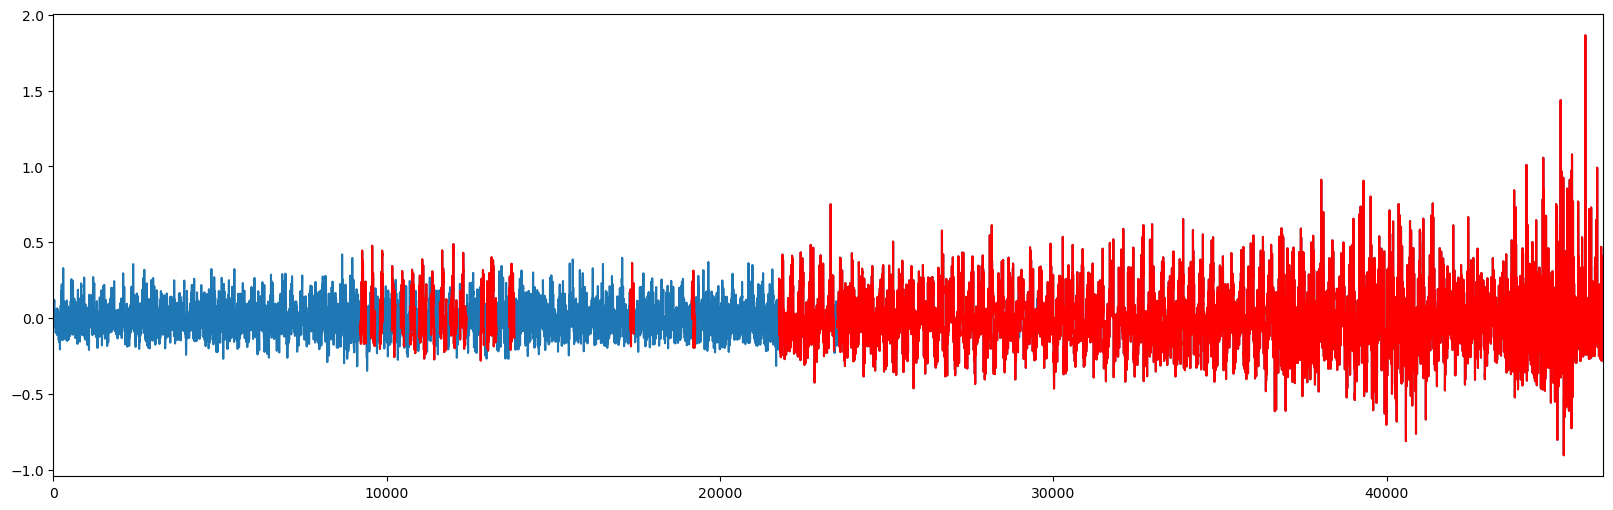

In [32]:
anomalous_data_indices = [False] * len(val_exp_rms)
np.array(anomalous_data_indices)
for i, anom in enumerate(anomalies):
    if anom:
        for j in range(i, (i + SEQ_LEN - 1)):
            anomalous_data_indices[j] = True

df_full_rms = pd.DataFrame(val_exp_rms)
df_anom = df_full_rms.copy()
df_anom.loc[np.invert(anomalous_data_indices)] = np.nan

fig, ax = plt.subplots(figsize=(20, 6))
df_full_rms.plot(legend=False, ax=ax)
df_anom.plot(legend=False, ax=ax, color="r")
plt.autoscale(enable=True, axis='x', tight=True)

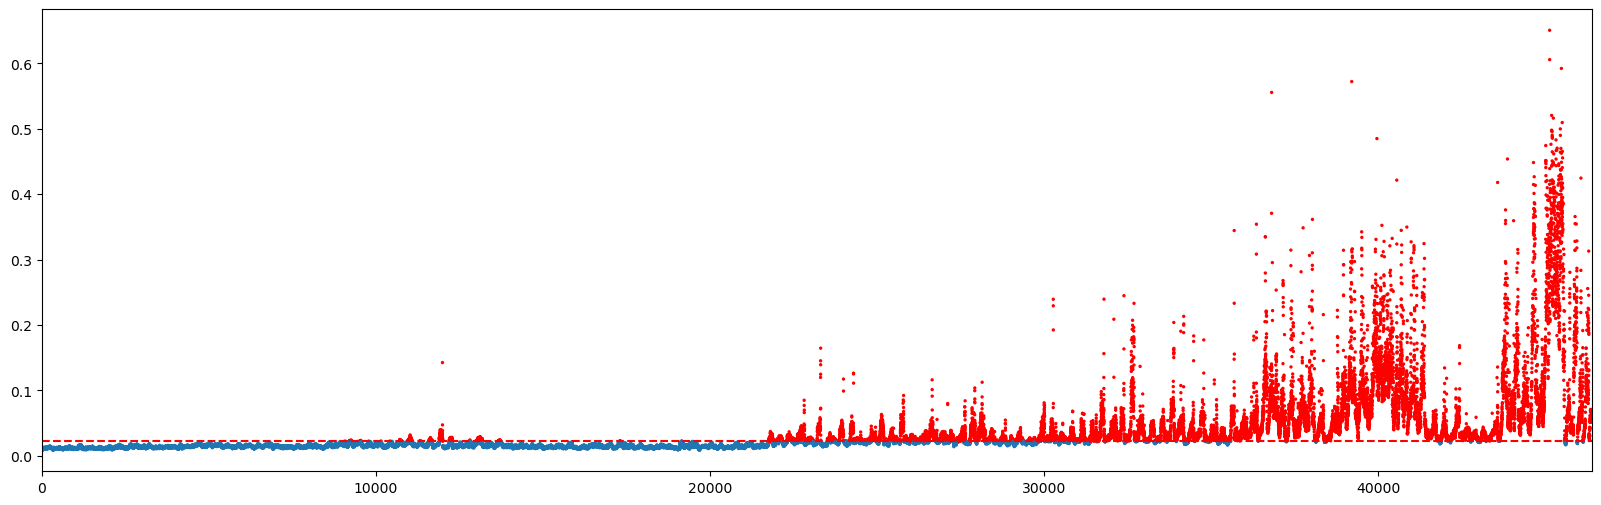

In [33]:
mae = np.concatenate([train_mae_loss, test_mae_loss], axis=0)

cmap = []
for m in mae:
    if m > THRESHOLD:
        cmap.append('r')
    else:
        cmap.append('C0')

fig, ax = plt.subplots(figsize=(20, 6))
plt.scatter(x=range(len(mae)), y=mae, c=cmap, s=2)
ax.axhline(y=THRESHOLD, color='r', linestyle='--')
plt.autoscale(enable=True, axis='x', tight=True)

In [34]:
exp_data = resources.load('Test 9')

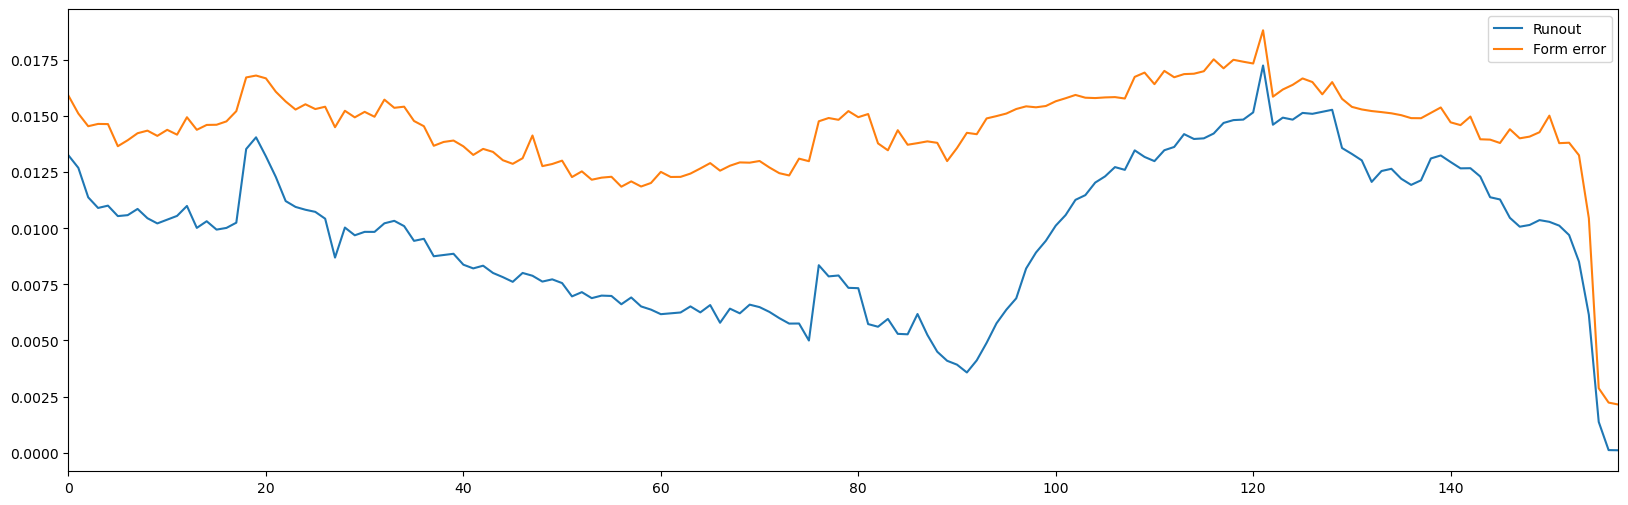

In [35]:
fig, ax = plt.subplots(figsize=(20, 6))
exp_data.features.plot(y=['Runout', 'Form error'], ax=ax)
plt.autoscale(enable=True, axis='x', tight=True)